In [1]:
import os
import pandas as pd

def load_dataset_as_dataframe(subdir):
    # Define the path to the dataset
    data_dir = f'/kaggle/input/knee-osteoarthritis-dataset-with-severity/{subdir}'
    print(f'Load dataset from `{subdir}` subdirectory')

    # Create lists to store image paths and labels
    image_paths = []
    labels = []

    # Get the list of class directories
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    classes.sort()
    print('Classes:', classes)

    # Map class names to labels
    class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}

    # Loop over each class directory
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        label = class_to_idx[class_name]
        # Get all image files in the class directory
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if os.path.isfile(img_path):
                image_paths.append(img_path)
                labels.append(label)

    # Create a DataFrame
    data = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })
    
    # Show the distribution of labels in the dataset
    dataset_distribution_dict = {}
    for i in range(5):
        dataset_distribution_dict[i] = len(data[data['label'] == i])
    print(dataset_distribution_dict)
    print()

    return data

In [2]:
# Prepare training and test dataset as dataframes
classes = ['0', '1', '2', '3', '4']
train_df = load_dataset_as_dataframe('train')
test_df = load_dataset_as_dataframe('test')

Load dataset from `train` subdirectory
Classes: ['0', '1', '2', '3', '4']
{0: 2286, 1: 1046, 2: 1516, 3: 757, 4: 173}

Load dataset from `test` subdirectory
Classes: ['0', '1', '2', '3', '4']
{0: 639, 1: 296, 2: 447, 3: 223, 4: 51}



In [3]:
from torchvision import transforms

# Define image transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet standards
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [9]:
from torch.utils.data import Dataset
from PIL import Image

# Create custom dataset class
class KneeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        label = self.df.loc[idx, 'label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [10]:
from torch.utils.data import DataLoader

# Create dataset instances
train_dataset = KneeDataset(train_df, transform=train_transform)
test_dataset = KneeDataset(test_df, transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


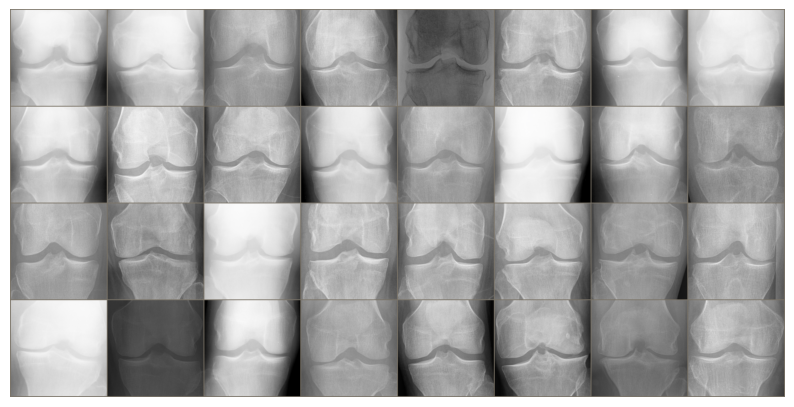

In [12]:
import numpy as np
from torchvision import utils
import matplotlib.pyplot as plt

# Function to display images
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img  = std * img + mean
    img  = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Get a batch of training data
images, labels = next(iter(train_loader))

# Make a grid from batch
out = utils.make_grid(images)

# Display images
plt.figure(figsize=(10, 10))
imshow(out)
plt.show()


In [14]:
from torchvision import models
import torch.nn as nn

# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the final layer
num_ftrs = model.fc.in_features
num_classes = len(classes)
model.fc = nn.Linear(num_ftrs, num_classes)


In [16]:
import torch
import torch.optim as optim

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [1]:
from tqdm import tqdm

# Number of epochs
num_epochs = 25

# Training loop with progress bars
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    # Wrap the train_loader with tqdm for a progress bar
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item() * images.size(0)
        
        # Calculate accuracy within the batch
        _, preds = torch.max(outputs, 1)
        total_correct += torch.sum(preds == labels.data)
        total_samples += labels.size(0)
        
        # Update progress bar description
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{(total_correct/total_samples*100):.2f}%'
        })
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = total_correct.double() / len(train_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

NameError: name 'model' is not defined

In [ ]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy on test set: {accuracy:.4f}')

# Classification report
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()